# Lab 11-2: Sequence Model of RNN (TensorFlow)
## Exercise: Character-based Text Generation with Embedding
This exercise is based on the notebook in TensorFlow Tutorials.<br>
https://www.tensorflow.org/text/tutorials/text_generation

Load Libraries & Dataset

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import time

(ds, ), ds_info = tfds.load(name='tiny_shakespeare', split=['train'], with_info=True)

ds = ds.map(lambda x: tf.strings.unicode_split(x['text'], 'UTF-8'))
for sample in ds.take(1): 
    text_str = sample

print(ds_info)
print('Total number of characters:', len(text_str))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/tiny_shakespeare/1.0.0.incompleteYAMNWJ/tiny_shakespeare-train.tfrecord


  0%|          | 0/1 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/tiny_shakespeare/1.0.0.incompleteYAMNWJ/tiny_shakespeare-validation.tfrecord


  0%|          | 0/1 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/tiny_shakespeare/1.0.0.incompleteYAMNWJ/tiny_shakespeare-test.tfrecord


  0%|          | 0/1 [00:00<?, ? examples/s]

Dataset tiny_shakespeare downloaded and prepared to /root/tensorflow_datasets/tiny_shakespeare/1.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='tiny_shakespeare',
    version=1.0.0,
    description='40,000 lines of Shakespeare from a variety of Shakespeare's plays. Featured in Andrej Karpathy's blog post 'The Unreasonable Effectiveness of Recurrent Neural Networks': http://karpathy.github.io/2015/05/21/rnn-effectiveness/.

To use for e.g. character modelling:

```
d = tfds.load(name='tiny_shakespeare')['train']
d = d.map(lambda x: tf.strings.unicode_split(x['text'], 'UTF-8'))
# train split includes vocabulary for other splits
vocabulary = sorted(set(next(iter(d)).numpy()))
d = d.map(lambda x: {'cur_char': x[:-1], 'next_char': x[1:]})
d = d.unbatch()
seq_len = 100
batch_size = 2
d = d.batch(seq_len)
d = d.batch(batch_size)
```',
    homepage='https://github.com/karpathy/char-rnn/blob/master/data/tinyshakespeare/input.txt',
    features=FeaturesDict({
      

In [2]:
vocabulary = sorted(set(text_str.numpy()))
# train split includes vocabulary for other splits

char_to_index = dict((char, index) for index, char in enumerate(vocabulary))

index_to_char = {}
for key, value in char_to_index.items():
    index_to_char[value] = key

print('The number of character indexs:', len(vocabulary))
print('Character to Index Mapping:\n', char_to_index)

The number of character indexs: 65
Character to Index Mapping:
 {b'\n': 0, b' ': 1, b'!': 2, b'$': 3, b'&': 4, b"'": 5, b',': 6, b'-': 7, b'.': 8, b'3': 9, b':': 10, b';': 11, b'?': 12, b'A': 13, b'B': 14, b'C': 15, b'D': 16, b'E': 17, b'F': 18, b'G': 19, b'H': 20, b'I': 21, b'J': 22, b'K': 23, b'L': 24, b'M': 25, b'N': 26, b'O': 27, b'P': 28, b'Q': 29, b'R': 30, b'S': 31, b'T': 32, b'U': 33, b'V': 34, b'W': 35, b'X': 36, b'Y': 37, b'Z': 38, b'a': 39, b'b': 40, b'c': 41, b'd': 42, b'e': 43, b'f': 44, b'g': 45, b'h': 46, b'i': 47, b'j': 48, b'k': 49, b'l': 50, b'm': 51, b'n': 52, b'o': 53, b'p': 54, b'q': 55, b'r': 56, b's': 57, b't': 58, b'u': 59, b'v': 60, b'w': 61, b'x': 62, b'y': 63, b'z': 64}


In [3]:
# Code to show how data is prepared

ids_from_chars = tf.keras.layers.StringLookup(vocabulary=list(vocabulary), mask_token=None)
chars_from_ids = tf.keras.layers.StringLookup(vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

text_ids = ids_from_chars(text_str)

n_voca = len(ids_from_chars.get_vocabulary())

seq_len = 128

ds_ids = tf.data.Dataset.from_tensor_slices(text_ids).batch(seq_len+1, drop_remainder=True)

ds_xy = ds_ids.map(lambda x: (x[:-1], x[1:]))

In [4]:
for seq in ds_ids.take(1):
    print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' ' b'a' b'r' b'e' b' ' b'a' b'l' b'l' b' ' b'r' b'e' b's'
 b'o' b'l' b'v' b'e' b'd' b' ' b'r' b'a' b't' b'h' b'e' b'r' b' ' b't'
 b'o' b' ' b'd'], shape=(129,), dtype=string)


In [5]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

for sample in ds_xy.take(1):
    input_example, target_example = sample
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to '
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to d'


In [6]:
buff_size = 10000
batch_size = 64
ds_train = ds_xy.shuffle(buff_size).batch(batch_size, drop_remainder=True)

ds_train

<BatchDataset element_spec=(TensorSpec(shape=(64, 128), dtype=tf.int64, name=None), TensorSpec(shape=(64, 128), dtype=tf.int64, name=None))>

Note: All layers in a Sequential model should have a single output tensor. For multi-output layers, use the functional API.
For training you could use a keras.Sequential model here. To generate text later you'll need to manage the RNN's internal state. It's simpler to include the state input and output options upfront, than it is to rearrange the model architecture later. 

How to use tf.keras.layers.RNN
```Python
cell = tf.keras.layers.SimpleRNNCell(units=hidden_size) 
rnn = tf.keras.layers.RNN(cell, return_sequences=True, return_state=True) # Or use tf.keras.layers.SimpleRNN
outputs, states = rnn(X_data)
```

A `get_initial_state(inputs=None, batch_size=None, dtype=None)` method that creates a tensor meant to be fed to `call()` as the initial state, if the user didn't specify any initial state via other means. The returned initial state should have a shape of `[batch_size, cell.state_size]`. The cell might choose to create a tensor full of zeros, or full of other values based on the cell's implementation.

In [17]:
n_voca = len(ids_from_chars.get_vocabulary())

# Number of word vector
n_embedding = 256
# Number of RNN units
n_hidden = 512

class myRNN(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__(self)
    
        ### START CODE HERE ### 

        self.embedding = tf.keras.layers.Embedding(vocab_size, n_embedding)
        self.rnn = tf.keras.layers.SimpleRNN(rnn_units,
                                        activation='tanh',
                                        use_bias=True,
                                        kernel_initializer='glorot_uniform',      # Whx
                                        recurrent_initializer='orthogonal',   # Whh
                                        return_sequences= True,        # whole hidden states ht
                                        return_state= True)           # last hidden state ht[-1]
        self.dense = tf.keras.layers.Dense(vocab_size,
                                        activation=None,
                                        use_bias=True,
                                        kernel_initializer='glorot_uniform')
                                        
        ### END CODE HERE ###

    def call(self, inputs, states=None, return_state=False, training=False):
        ### START CODE HERE ### 
    
        x = self.embedding(inputs, training=training)
        if states is None:  # if(states==None) initilize states.
            states = self.rnn.get_initial_state(x)
        x, states = self.rnn(x, initial_state=states, training=training)
        x = self.dense(x, training=training)
        
        ### END CODE HERE ###
    
        if return_state:
            return x, states
        else:
            return x

RNN = myRNN(vocab_size=n_voca, embedding_dim=n_embedding, rnn_units=n_hidden)


Test Model before training

In [18]:
RNN.build(input_shape=(None,seq_len))
RNN.call(tf.keras.Input(shape=(seq_len)))

for input_example_batch, target_example_batch in ds_train.take(1):
    example_batch_predictions = RNN(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 128, 66) # (batch_size, sequence_length, vocab_size)


In [19]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'e odds be great,\nI doubt not, uncle, of our victory.\nMany a battle have I won in France,\nWhen as the enemy hath been ten to one:'

Next Char Predictions:
 b"h$3KxLnr&\nA[UNK]W&-dD;nkS&obXSy gwtPlWx,JREGj!Fjn\nfgfan!xoe IL$Z[UNK]g:QUL,I'Fqqe$hslfJ[UNK]Sq uryt'qUwuCXK:WgWuolHZ:r-Kaa&VLZHjSafNM'\n::Gzr"


In [20]:
RNN.summary()

Model: "my_rnn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 128, 256)          16896     
                                                                 
 simple_rnn_1 (SimpleRNN)    [(None, 128, 512),        393728    
                              (None, 512)]                       
                                                                 
 dense_1 (Dense)             (None, 128, 66)           33858     
                                                                 
Total params: 444,482
Trainable params: 444,482
Non-trainable params: 0
_________________________________________________________________


In [21]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opti = tf.keras.optimizers.Adam(learning_rate=1e-3)
metr = tf.keras.metrics.SparseCategoricalCrossentropy(name='acc')
RNN.compile(loss= loss, optimizer=opti, metrics=[metr])

In [22]:
n_epochs = 30

results = RNN.fit(ds_train, epochs=n_epochs, verbose=1)

Epoch 1/30
121/121 [==============================] - 20s 150ms/step - loss: 2.6979 - acc: 3.8586
Epoch 2/30
121/121 [==============================] - 17s 119ms/step - loss: 2.1242 - acc: 3.2488
Epoch 3/30
121/121 [==============================] - 14s 108ms/step - loss: 1.9447 - acc: 3.2022
Epoch 4/30
121/121 [==============================] - 14s 108ms/step - loss: 1.8195 - acc: 3.1703
Epoch 5/30
121/121 [==============================] - 14s 107ms/step - loss: 1.7256 - acc: 3.1499
Epoch 6/30
121/121 [==============================] - 14s 107ms/step - loss: 1.6562 - acc: 3.1367
Epoch 7/30
121/121 [==============================] - 15s 113ms/step - loss: 1.6041 - acc: 3.1280
Epoch 8/30
121/121 [==============================] - 14s 109ms/step - loss: 1.5616 - acc: 3.1212
Epoch 9/30
121/121 [==============================] - 14s 108ms/step - loss: 1.5265 - acc: 3.1174
Epoch 10/30
121/121 [==============================] - 15s 113ms/step - loss: 1.4981 - acc: 3.1129
Epoch 11/30
121/121

Plot Convergence Graph

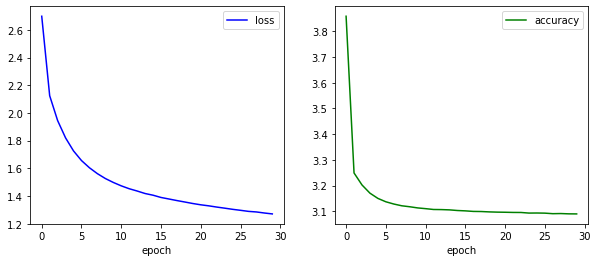

In [23]:
# plot loss and accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(results.history['loss'], 'b-', label='loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(results.history['acc'], 'g-', label='accuracy')
plt.xlabel('epoch')
plt.legend()

plt.show()

### Test Model with a random word vector
This model generates multiple sentences.<br>
But the resulting sentences does not have any content.

In [24]:
class OneStep(tf.keras.Model):
    def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
        super().__init__()
        self.temperature = temperature
        self.model = model
        self.chars_from_ids = chars_from_ids
        self.ids_from_chars = ids_from_chars
    
        # Create a mask to prevent "[UNK]" from being generated.
        skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
        sparse_mask = tf.SparseTensor(
            # Put a -inf at each bad index.
            values=[-float('inf')]*len(skip_ids),
            indices=skip_ids,
            # Match the shape to the vocabulary
            dense_shape=[len(ids_from_chars.get_vocabulary())])
        self.prediction_mask = tf.sparse.to_dense(sparse_mask)

    @tf.function
    def generate_one_step(self, inputs, states=None):
        # Convert strings to token IDs.
        input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
        input_ids = self.ids_from_chars(input_chars).to_tensor()
    
        # Run the model.
        # predicted_logits.shape is [batch, char, next_char_logits]
        predicted_logits, states = self.model(inputs=input_ids, states=states,
                                              return_state=True)
        # Only use the last prediction.
        predicted_logits = predicted_logits[:, -1, :]
        predicted_logits = predicted_logits/self.temperature
        # Apply the prediction mask: prevent "[UNK]" from being generated.
        predicted_logits = predicted_logits + self.prediction_mask
    
        # Sample the output logits to generate token IDs.
        predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
        predicted_ids = tf.squeeze(predicted_ids, axis=-1)
    
        # Convert from token ids to characters
        predicted_chars = self.chars_from_ids(predicted_ids)
    
        # Return the characters and model state.
        return predicted_chars, states

In [25]:
one_step_model = OneStep(RNN, chars_from_ids, ids_from_chars)

In [26]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
    next_char, states = one_step_model.generate_one_step(next_char, states=states)
    result.append(next_char)

result = tf.strings.join(result)
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', time.time() - start)

ROMEO:
Dram blessing he slough a town;
Fear with the omanless hand;
Let it for their life or ladies unto you to tune you untress'd;
This Marget! hees drawn before
Night by Edward, word great good Plantagenes,
That shed him your crown.

CORIOLANUS:
Asteer well rest to the wind or
Weaty too quickly sent, grounds
Shall scent a maidly confured together:
The king wish it not so hells,
Their sunseis' heed.

SICINIUS:
'Tis true.

LUCIO:
O trust emngy that Claudio children' all!
When do the vassing wife's alaughterous full:
He halp within a painterfold
As little blast.

ROMEO:
Too feath, to what?

GLOUCESTER:
What, bickers that Bicland,
'me to a visican: poor soul! this? in eave to him
into the appeof from from the cause must need.

PERDITA:
No, in those burst to speak,
That in my, if
they are true, to respect
of Catesbyrance, Edward, in Claudion equal breast.
Veron, might, Edward will, to afflicious may
Thou oath shall, as they granted
The business my deed for Catused with beyond capal to the